# Titanic kaggle competition

The following notebook contains my attempt at the titanic kaggle competition: https://www.kaggle.com/competitions/titanic/overview. 

## Data dictionary

| Variable   | Definition                        | Key                               |
|------------|----------------------------------|----------------------------------|
| survival   | Survival                          | 0 = No, 1 = Yes                  |
| pclass     | Ticket class                      | 1 = 1st, 2 = 2nd, 3 = 3rd       |
| sex        | Sex                               |                                  |
| Age        | Age in years                      |                                  |
| sibsp      | # of siblings / spouses aboard    |                                  |
| parch      | # of parents / children aboard    |                                  |
| ticket     | Ticket number                     |                                  |
| fare       | Passenger fare                    |                                  |
| cabin      | Cabin number                      |                                  |
| embarked   | Port of Embarkation               | C = Cherbourg, Q = Queenstown, S = Southampton |


# Section 1 - Data import and overview

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier


from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


In [7]:
pct_missing = train_df.isnull().sum()/len(train_df)*100
pct_missing.round(2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

# Section 2 - Data investigation and feature engineering


## Section 2.1 - Family size

In [8]:
# survival by ticket class
train_df.groupby(["Pclass"], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
# survival by sex
train_df.groupby(["Sex"], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [10]:
# survival by no. siblings/ spouses
train_df.groupby(["SibSp"], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
# survival by no. parents
train_df.groupby(["Parch"], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [12]:
train_df["family_size"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["family_size"] = test_df["SibSp"] + test_df["Parch"] + 1

In [13]:
# survival by family size
train_df.groupby(["family_size"], as_index=False)['Survived'].mean()

,family_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [14]:
family_map = {
    1: 'Alone',
    2: 'Small',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Large',
    8: 'Large',
    11: 'Large'}
train_df['family_size_grouped'] = train_df['family_size'].map(family_map)
test_df['family_size_grouped'] = train_df['family_size'].map(family_map)

In [15]:
# survival by family size
train_df.groupby(["family_size_grouped"], as_index=False)['Survived'].mean()

,family_size_grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


## Section 2.2 - Embark Location

In [16]:
# survival by embark location
train_df.groupby(["Embarked"], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


## Section 2.3 - Age

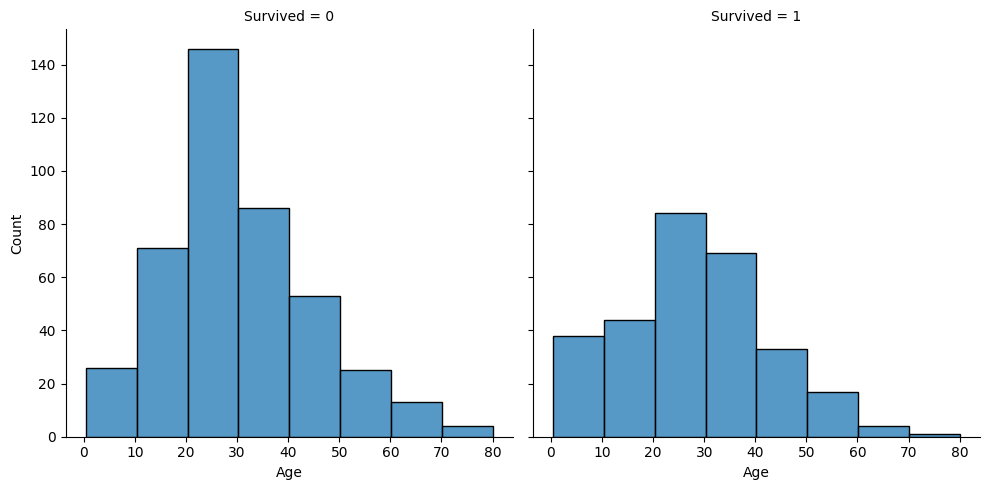

In [17]:
sns.displot(train_df, x='Age', col='Survived', binwidth=10, height=5)
plt.show()

In [18]:
train_df['age_cut'] = pd.qcut(train_df['Age'], 8)
test_df['age_cut'] = pd.qcut(test_df['Age'], 8)

In [19]:
 # survival by Age (cut)
train_df.groupby(["age_cut"], as_index=False, observed=True)['Survived'].mean()

,age_cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [20]:
# encode ages
bins = [0, 16, 20.125, 24, 28, 32.312, 38, 47, 80]
labels = [0,1,2,3,4,5,6,7]

train_df['age_group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=True)
test_df['age_group']  = pd.cut(test_df['Age'], bins=bins, labels=labels, right=True)

## Section 2.4 - Fare

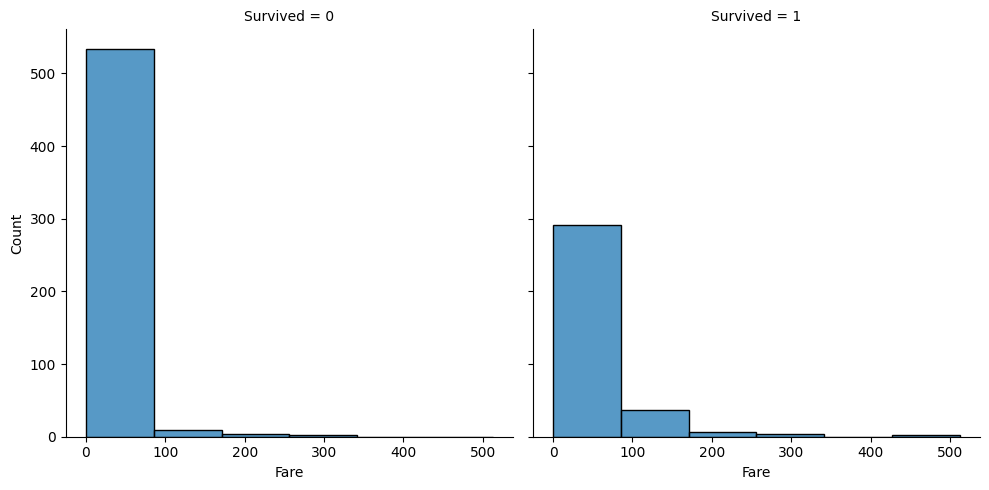

In [21]:
sns.displot(train_df, x='Fare', col='Survived', binwidth=80, height=5)
plt.show()

In [22]:
train_df['fare_cut'] = pd.qcut(train_df['Fare'], 6)
test_df['fare_cut'] = pd.qcut(test_df['Fare'], 6)

In [23]:
 # survival by fare (cut)
train_df.groupby(["fare_cut"], as_index=False, observed=True)['Survived'].mean()

,fare_cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [24]:
# encode fares
bins = [7.775, 8.662, 14.454, 26, 52.369]
labels = [0,1,2,3]

train_df['fare_group'] = pd.cut(train_df['Fare'], bins=bins, labels=labels, right=True)
test_df['fare_group']  = pd.cut(test_df['Fare'], bins=bins, labels=labels, right=True)

## Section 2.5 - Name

In [25]:
train_df["title"] = train_df['Name'].str.split(pat=",", expand=True)[1].str.split(pat=".", expand=True)[0].apply(lambda x:x.strip())
test_df["title"] = test_df['Name'].str.split(pat=",", expand=True)[1].str.split(pat=".", expand=True)[0].apply(lambda x:x.strip())

In [26]:
train_df["title"] = train_df['title'].replace({
    "Capt": "Military",
    "Col": "Military",
    "Major": "Military",
    "Jonkheer": "Noble",
    "the Countess": "Noble",
    "Don": "Noble",
    "Lady": "Noble",
    "Sir": "Noble",
    "Mlle": "Noble",
    "Ms": "Noble",
    "Mme": "Noble",
})

test_df["title"] = test_df['title'].replace({
    "Capt": "Military",
    "Col": "Military",
    "Major": "Military",
    "Jonkheer": "Noble",
    "the Countess": "Noble",
    "Don": "Noble",
    "Lady": "Noble",
    "Sir": "Noble",
    "Mlle": "Noble",
    "Ms": "Noble",
    "Mme": "Noble",
})

In [27]:
 # survival by title
train_df.groupby(["title"], as_index=False, observed=True)['Survived'].agg(['count', 'mean'])

,title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


In [28]:
train_df['name_length'] = train_df['Name'].apply(lambda x: len(x))
test_df['name_length'] = test_df['Name'].apply(lambda x: len(x))

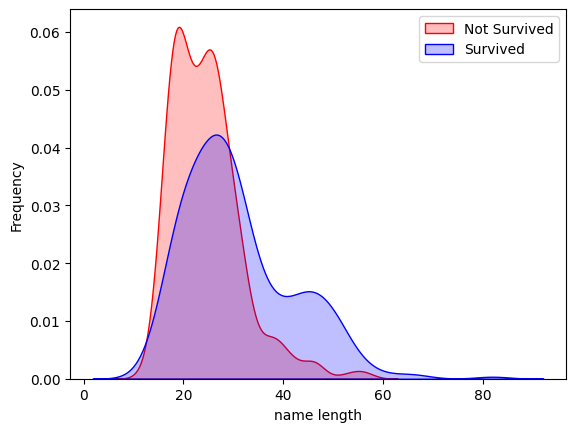

In [29]:
plot = sns.kdeplot(train_df['name_length'][(train_df['Survived']==0) & (train_df['name_length'].notnull())], color='Red', fill=True)
plot = sns.kdeplot(train_df['name_length'][(train_df['Survived']==1) & (train_df['name_length'].notnull())], ax=plot, color='Blue', fill=True)
plot.set_xlabel('name length')
plot.set_ylabel('Frequency')
plot = plot.legend(['Not Survived', 'Survived'])

In [30]:
train_df['name_length_group'] = pd.qcut(train_df['name_length'], 8)
test_df['name_length_group'] = pd.qcut(test_df['name_length'], 8)

In [31]:
 # survival by name length
train_df.groupby(["name_length_group"], as_index=False, observed=True)['Survived'].mean()

,name_length_group,Survived
0,"(11.999, 18.0]",0.214286
1,"(18.0, 20.0]",0.252427
2,"(20.0, 23.0]",0.307692
3,"(23.0, 25.0]",0.346939
4,"(25.0, 27.25]",0.292929
5,"(27.25, 30.0]",0.428571
6,"(30.0, 38.0]",0.517241
7,"(38.0, 82.0]",0.745283


In [32]:
# encode name_length
bins = [18, 20, 23, 25, 27.25, 30, 38, 82]
labels = [0,1,2,3,4,5,6]

train_df['name_length_group'] = pd.cut(train_df['name_length'], bins=bins, labels=labels, right=True)
test_df['name_length_group'] = pd.cut(test_df['name_length'], bins=bins, labels=labels, right=True)

## Section 2.6 - Ticket

In [33]:
train_df['ticket_number'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df['ticket_number'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [34]:
 # survival by ticket number
train_df.groupby(["ticket_number"], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,ticket_number,count,mean
196,2343,7,0.000000
464,347082,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
674,8475,1,0.000000
675,851,1,0.000000
676,9234,1,1.000000
63,11769,1,1.000000


In [35]:
 # survival by ticket number
train_df.groupby("ticket_number")['ticket_number'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: ticket_number, Length: 891, dtype: int64

In [36]:
train_df["ticket_number_count"] = train_df.groupby("ticket_number")['ticket_number'].transform('count')
test_df["ticket_number_count"] = test_df.groupby("ticket_number")['ticket_number'].transform('count')

In [37]:
 # survival by ticket number count
train_df.groupby(["ticket_number_count"], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,ticket_number_count,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [38]:
train_df['Ticket'].str.split(pat = " ", expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [39]:
train_df['ticket_initial'] = np.where(train_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')
test_df['ticket_initial'] = np.where(test_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), test_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [40]:
train_df['ticket_initial'].value_counts()

ticket_initial
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
C               5
S.O.C.          5
SC/PARIS        5
F.C.C.          5
SC/Paris        4
A/4.            3
PP              3
A/4             3
S.O./P.P.       3
SC/AH           3
A./5.           2
P/PP            2
A.5.            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.C./A.4.       1
Fa              1
S.O.P.          1
SO/C            1
S.P.            1
A4.             1
W.E.P.          1
A/S             1
SC              1
SW/PP           1
SCO/W           1
W/C             1
S.W./PP         1
F.C.            1
C.A./SOTON      1
Name: count, dtype: int64

In [41]:
train_df['ticket_initial'] = train_df['ticket_initial'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

test_df['ticket_initial'] = test_df['ticket_initial'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [42]:
 # survival by intial part of the ticket
train_df.groupby(["ticket_initial"], as_index=False)['Survived'].agg(['count', 'mean'])

,ticket_initial,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


## Section 2.7 - Cabin

In [43]:
train_df['Cabin'] = train_df['Cabin'].fillna('U') # U=unassigned
train_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin']])

test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test_df['Cabin']])

In [44]:
 # survival by cabin
train_df.groupby(["Cabin"], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


- In general, people with cabins had above average survival rate, so we simplify this into a binary variable, 1 if you had a cabin and 0 else.

In [45]:
train_df["cabin_assigned"] = train_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_df["cabin_assigned"] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [46]:
 # survival by cabin (binary)
train_df.groupby(["cabin_assigned"], as_index=False)['Survived'].agg(['count', 'mean'])

,cabin_assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


# Section 3 - data wrangling

fill some missing values

In [47]:
train_df.shape

(891, 25)

In [48]:
test_df.shape

(418, 24)

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  family_size          891 non-null    int64   
 13  family_size_grouped  891 non-null    object  
 14  age_cut              714 non-null    category
 15  age_group            71

In [50]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'family_size',
       'family_size_grouped', 'age_cut', 'age_group', 'fare_cut', 'fare_group',
       'title', 'name_length', 'name_length_group', 'ticket_number',
       'ticket_number_count', 'ticket_initial', 'cabin_assigned'],
      dtype='object')

In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  family_size          418 non-null    int64   
 12  family_size_grouped  418 non-null    object  
 13  age_cut              332 non-null    category
 14  age_group            332 non-null    category
 15  fare_cut             41

In [129]:
# fill missing age values in train and test set

median_age = train_df['Age'].median()

train_df['Age'] = train_df['Age'].fillna(median_age)
test_df['Age']  = test_df['Age'].fillna(median_age)

In [130]:
# one missing fare value in the test dataset

median_fare = train_df['Fare'].median()

test_df['Fare'] = test_df['Fare'].fillna(median_fare)

# Section 4 - encoding

In [54]:
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder
SI = SimpleImputer(strategy='most_frequent')

In [55]:
ode_cols = ['family_size_grouped']
ohe_cols = ['Sex', 'Embarked', 'title']

In [134]:
X = train_df.drop(['Survived'], axis=1)
y = train_df['Survived']
X_test = test_df.drop(['age_cut', 'fare_cut', 'SibSp', 'Parch'], axis=1)

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y, random_state=4)

In [58]:
# replace missing with most common values, convert categories to integers
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [59]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))
])

In [124]:
# apply column transformation to relevant columns, drop others
col_trans = ColumnTransformer(transformers=[
    ('impute', SI, ['age_group']),
    ('ord_pipeline', ordinal_pipeline, ode_cols),
    ('ohe_pipeline', ohe_pipeline, ohe_cols),
    ('passthrough', 'passthrough', ['Pclass', 'Fare', 'name_length', 'ticket_number_count', 'cabin_assigned'])],
    remainder='drop',
    n_jobs=-1)

In [122]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  family_size          891 non-null    int64   
 13  family_size_grouped  891 non-null    object  
 14  age_cut              714 non-null    category
 15  age_group            71

# Section 5 - modelling

## Section 5.1 - Random forest classifier

In [61]:
rfc = RandomForestClassifier()

In [62]:
param_grid = {
    'n_estimators': [150, 200, 300, 500],
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 13, 15, 17, 20],
    'min_samples_leaf': [2, 4, 5, 6],
    'criterion': ['gini', 'entropy'],
}

In [63]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [64]:
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
pipefinalrfc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [65]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 150}
0.8412685905643652


## Section 5.2 - decision tree classifier

In [66]:
dtc = DecisionTreeClassifier()

In [67]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

In [68]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [69]:
pipefinaldtc = make_pipeline(col_trans, CV_dtc)
pipefinaldtc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [70]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.814606520240323


## 5.3 knn classifier

In [71]:
knn = KNeighborsClassifier()

In [72]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2],
}

In [73]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [74]:
pipefinalknn = make_pipeline(col_trans, CV_knn)
pipefinalknn.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [75]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
0.7977445090121147


## section 5.4 - SVC

In [76]:
svc = SVC(probability=True)

In [77]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
}

In [78]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [79]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [80]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 100, 'kernel': 'linear'}
0.8216290751502019


## Section 5.5 - logisitic regression

In [81]:
lr = LogisticRegression()

In [82]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
}

In [83]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [84]:
pipefinallr= make_pipeline(col_trans, CV_lr)
pipefinallr.fit(X_train, y_train)

C:\Users\kiera\miniconda3\envs\titanic-kaggle\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kiera\miniconda3\envs\titanic-kaggle\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [85]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 1.0}
0.8286220821432089


## section 5.6 - GaussianNB

In [86]:
gnb = GaussianNB()

In [87]:
param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001],
}

In [88]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [89]:
pipefinalgnb= make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [90]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.783699399192357


## Section 5.6 - XGB Classifier

In [91]:
xg = XGBClassifier()

In [92]:
param_grid = {
     'booster': ['gbtree', 'gblinear','dart'],
}

In [93]:
CV_xg = GridSearchCV(estimator=xg, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [94]:
pipefinalxg= make_pipeline(col_trans, CV_xg)
pipefinalxg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [95]:
print(CV_xg.best_params_)
print(CV_xg.best_score_)

{'booster': 'gblinear'}
0.828592534226337


## Section 5.7 - ABC

In [96]:
abc = AdaBoostClassifier()

In [97]:
dtc_2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10,min_samples_leaf=4, min_samples_split=10)  
svc_2 = SVC(probability=True, C=10, kernel='rbf') 
lr_2 = LogisticRegression(C=0.1) 
lr_3 = LogisticRegression(C=0.2) 
lr_4 = LogisticRegression(C=0.05) 

In [101]:
param_grid = {
    'estimator': [dtc_2, svc_2, lr_2], 
    'n_estimators':  [5, 10, 25, 50, 100],
    'learning_rate': [(0.97 + x / 100) for x in range(1, 7)]  
}

In [102]:
CV_abc = GridSearchCV(estimator=abc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [103]:
pipefinalabc= make_pipeline(col_trans, CV_abc)
pipefinalabc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [104]:
print(CV_abc.best_params_)
print(CV_abc.best_score_)

{'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10), 'learning_rate': 1.0, 'n_estimators': 100}
0.8033192159952722


## Section 5.8 - ETC

In [105]:
etc = ExtraTreesClassifier()

In [106]:
param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[100,300],
}

In [107]:
CV_etc = GridSearchCV(estimator=etc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [108]:
pipefinaletc= make_pipeline(col_trans, CV_etc)
pipefinaletc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [109]:
print(CV_etc.best_params_)
print(CV_etc.best_score_)

{'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
0.832837584950261


## Section 5.9 - GBC

In [110]:
GBC = GradientBoostingClassifier()

In [111]:
param_grid = {
              'n_estimators' : [300, 400, 500],
              'learning_rate': [ 0.1, 0.3, 0.6, 1.0],
              'max_depth': [8, 10, 12],
              'min_samples_leaf': [50, 100, 120, 150],
              'max_features': [0.1, 0.3, 0.5] 
              }

In [112]:
CV_gbc = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [113]:
pipefinalgbc= make_pipeline(col_trans, CV_gbc)
pipefinalgbc.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('gridsearchcv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [114]:
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)

{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 500}
0.8384713877671626


## Section 5.10 - Voting Classifier

In [115]:
vc1 = VotingClassifier([('gbc', CV_gbc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )

In [116]:
vc2 = VotingClassifier([('abc', CV_abc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )
#1,2,3 is the best performing one

In [117]:
pipefinalcv1 = make_pipeline(col_trans, vc1)

In [118]:
pipefinalcv2 = make_pipeline(col_trans, vc2)

In [119]:
pipefinalcv1.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('votingclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output

In [120]:
pipefinalcv2.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('votingclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('impute', ...), ('ord_pipeline', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output

In [135]:
Y_pred = pipefinalrfc.predict(X_test)
Y_pred2 = pipefinaldtc.predict(X_test)
Y_pred3 = pipefinalknn.predict(X_test)
Y_pred4 = pipefinalsvc.predict(X_test)
Y_pred5 = pipefinallr.predict(X_test)
Y_pred6 = pipefinalgnb.predict(X_test)
Y_pred7 = pipefinalxg.predict(X_test)
Y_pred8 = pipefinalabc.predict(X_test)
Y_pred9 = pipefinaletc.predict(X_test)
Y_pred10 = pipefinalgbc.predict(X_test)
Y_pred11 = pipefinalcv1.predict(X_test)
Y_pred12 = pipefinalcv2.predict(X_test)

In [136]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred
})

submission2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred2
})

submission3 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred3
})

submission4 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred4
})

submission5 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred5
})

submission6 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred6
})

submission7 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred7
})

submission8 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred8
})

submission9 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred9
})

submission10 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred10
})

submission11 = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred11
})

submission12 = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred12
})

In [137]:
submission.to_csv('submission.csv', index=False)
submission2.to_csv('submission2.csv', index=False)
submission3.to_csv('submission3.csv', index=False)
submission4.to_csv('submission4.csv', index=False)
submission5.to_csv('submission5.csv', index=False)
submission6.to_csv('submission6.csv', index=False)
submission7.to_csv('submission7.csv', index=False)
submission8.to_csv('submission8.csv', index=False)
submission9.to_csv('submission9.csv', index=False)
submission10.to_csv('submission10.csv', index=False)
submission11.to_csv('submission11.csv', index=False)
submission12.to_csv('submission12.csv', index=False)